In [1]:
import sys
sys.path.append('/home/heye0507/apex')
from apex import amp

In [2]:
from glob import glob
from sklearn.model_selection import GroupKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import sklearn

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [3]:
# %%time

# df = []

# for label, kind in enumerate(['Cover', 'JMiPOD', 'JUNIWARD', 'UERD']):
#     for path in glob('/home/heye0507/alask2/data/Cover/*.jpg'):
#         df.append({
#             'kind': kind,
#             'image_name': path.split('/')[-1],
#             'label': label
#         })

# random.shuffle(df)
# df = pd.DataFrame(df)

In [4]:
# gkf = GroupKFold(n_splits=5)

# df.loc[:, 'fold'] = 0
# for fold_number, (train_index, val_index) in enumerate(gkf.split(X=df.index, y=df['label'], groups=df['image_name'])):
#     df.loc[df.iloc[val_index].index, 'fold'] = fold_number


In [5]:
df = pd.read_csv('/home/heye0507/alask2/data/group_split.csv')
df.head()

,kind,image_name,label,fold
0,JUNIWARD,71670.jpg,2,0
1,Cover,36988.jpg,0,3
2,JUNIWARD,39654.jpg,2,2
3,JMiPOD,41515.jpg,1,2
4,JMiPOD,46513.jpg,1,3


In [6]:
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        #A.Resize(height=512,width=512,p=1.0),
        A.Normalize(p=1.0),
        ToTensorV2(p=1.0),
    ],p=1.0)

def get_valid_transform():
    return A.Compose([
        #A.Resize(height=512,width=512,p=1.0),
        A.Normalize(p=1.0),
        ToTensorV2(p=1.0),
    ],p=1.0)

In [7]:
class Alask2Dataset(Dataset):
    def __init__(self,path,kinds,image_names,labels, transforms=None):
        super().__init__()
        self.kinds = kinds
        self.image_names = image_names
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.kinds)
    
    def __getitem__(self,idx):
        kind, image_name, label = self.kinds[idx], self.image_names[idx], self.labels[idx]
        image = cv2.imread(f'{path}/{kind}/{image_name}',cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
        if self.transforms:
            aug = self.transforms(
                image=image,
            )
            image= aug['image']
        target = self._onehot(4,label)
        return image, target
    
    def _onehot(self,size,target):
        vec = torch.zeros(size,dtype=torch.float32)
        vec[target] = 1.
        return vec
    
    def get_labels(self):
        return list(self.labels)

In [8]:
fold_number = 0
path = '/home/heye0507/alask2/data'

train_dataset = Alask2Dataset(
    path = path,
    kinds=df[df['fold'] != fold_number].kind.values,
    image_names=df[df['fold'] != fold_number].image_name.values,
    labels=df[df['fold'] != fold_number].label.values,
    transforms=get_train_transform(),
)

validation_dataset = Alask2Dataset(
    path = path,
    kinds=df[df['fold'] == fold_number].kind.values,
    image_names=df[df['fold'] == fold_number].image_name.values,
    labels=df[df['fold'] == fold_number].label.values,
    transforms=get_valid_transform(),
)

In [9]:
def denormalize(x:torch.tensor):
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])
    return x * std[...,None,None] + mean[...,None,None]

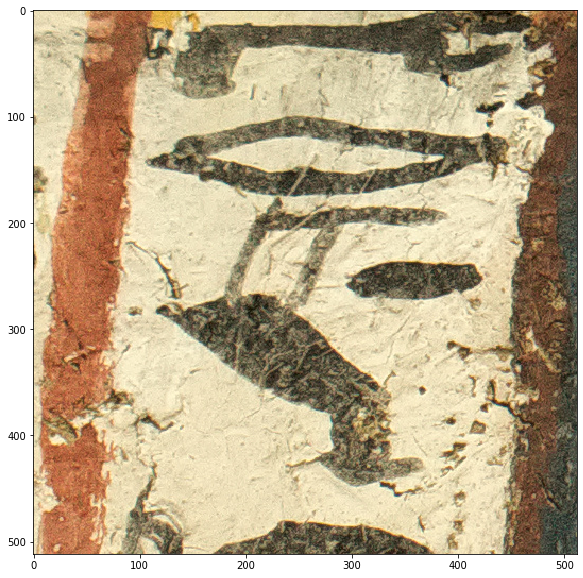

In [9]:
image, target = train_dataset[0]
image = denormalize(image)

image = image.permute(1,2,0).numpy()

fig, ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(image)

In [10]:
from sklearn import metrics

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
        
def alaska_weighted_auc(y_true, y_valid):
    """
    https://www.kaggle.com/anokas/weighted-auc-metric-updated
    """
    tpr_thresholds = [0.0, 0.4, 1.0]
    weights = [2, 1]

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_valid, pos_label=1)

    # size of subsets
    areas = np.array(tpr_thresholds[1:]) - np.array(tpr_thresholds[:-1])

    # The total area is normalized by the sum of weights such that the final weighted AUC is between 0 and 1.
    normalization = np.dot(areas, weights)

    competition_metric = 0
    for idx, weight in enumerate(weights):
        y_min = tpr_thresholds[idx]
        y_max = tpr_thresholds[idx + 1]
        mask = (y_min < tpr) & (tpr < y_max)
        if mask.sum() == 0:
            continue

        x_padding = np.linspace(fpr[mask][-1], 1, 100)

        x = np.concatenate([fpr[mask], x_padding])
        y = np.concatenate([tpr[mask], [y_max] * len(x_padding)])
        y = y - y_min  # normalize such that curve starts at y=0
        score = metrics.auc(x, y)
        submetric = score * weight
        best_subscore = (y_max - y_min) * weight
        competition_metric += submetric

    return competition_metric / normalization
        
class RocAucMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.y_true = np.array([0,1])
        self.y_pred = np.array([0.5,0.5])
        self.score = 0

    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().argmax(axis=1).clip(min=0, max=1).astype(int)
        y_pred = 1 - nn.functional.softmax(y_pred, dim=1).data.cpu().numpy()[:,0]
        self.y_true = np.hstack((self.y_true, y_true))
        self.y_pred = np.hstack((self.y_pred, y_pred))
        self.score = alaska_weighted_auc(self.y_true, self.y_pred)
    
    @property
    def avg(self):
        return self.score

In [11]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing = 0.1):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        if self.training:
            x = x.float()
            target = target.float()
            logprobs = torch.nn.functional.log_softmax(x, dim = -1)

            nll_loss = -logprobs * target
            nll_loss = nll_loss.sum(-1)
    
            smooth_loss = -logprobs.mean(dim=-1)

            loss = self.confidence * nll_loss + self.smoothing * smooth_loss

            return loss.mean()
        else:
            return torch.nn.functional.cross_entropy(x, target)

In [12]:
import warnings

warnings.filterwarnings("ignore")

opt_level ='O1' # apex

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0
        
        self.base_dir = f'/home/heye0507/alask2/models/{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
            
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        
        self.model, self.optimizer = amp.initialize(self.model,self.optimizer,opt_level=opt_level) # apex
        
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.criterion = LabelSmoothing().to(self.device)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss, final_scores = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss, final_scores = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        final_scores = RocAucMeter()
        t = time.time()
        for step, (images, targets) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                targets = targets.to(self.device).float()
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                outputs = self.model(images)
                loss = self.criterion(outputs, targets)
                final_scores.update(targets, outputs)
                summary_loss.update(loss.detach().item(), batch_size)
            
            if step == 20:
                break

        return summary_loss, final_scores

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        final_scores = RocAucMeter()
        t = time.time()
        for step, (images, targets) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            targets = targets.to(self.device).float()
            images = images.to(self.device).float()
            batch_size = images.shape[0]

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, targets)
            with amp.scale_loss(loss,self.optimizer) as scaled_loss: # apex
                scaled_loss.backward()
            #loss.backward()
            
            final_scores.update(targets, outputs)
            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()
            
            if step == 20:
                break

        return summary_loss, final_scores
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
            'amp': amp.state_dict() # apex
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [13]:
from efficientnet_pytorch import EfficientNet

In [14]:
def get_net():
    net = EfficientNet.from_pretrained('efficientnet-b2',num_classes=4)
    return net

net = get_net().cuda()
#net = get_net()

Loaded pretrained weights for efficientnet-b2


In [15]:
class TrainGlobalConfig:
    num_workers = 4
    batch_size = 32 
    n_epochs = 25
    lr = 0.001
    
    folder = 'effb2_fold0'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = True  # do scheduler.step after optimizer.step
    validation_scheduler = False  # do scheduler.step after validation stage loss

    SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
    scheduler_params = dict(
        max_lr=5e-4,
        epochs=n_epochs,
        steps_per_epoch=int(len(train_dataset) / batch_size),
        pct_start=0.3,
        anneal_strategy='cos', 
        final_div_factor=10**5
    )
    
#     SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
#     scheduler_params = dict(
#         mode='min',
#         factor=0.5,
#         patience=1,
#         verbose=False, 
#         threshold=0.0001,
#         threshold_mode='abs',
#         cooldown=0, 
#         min_lr=1e-8,
#         eps=1e-08
#     )
    # --------------------

In [16]:
def run_training():
    device = torch.device('cuda:0')

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        sampler=RandomSampler(train_dataset),
        batch_size=TrainGlobalConfig.batch_size,
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
#     fitter.load(f'{fitter.base_dir}/last-checkpoint.bin')
    fitter.fit(train_loader, val_loader)

In [17]:
run_training()

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Fitter prepared. Device is cuda:0

2020-06-30T07:53:59.592100
LR: 1.9999999999999998e-05
[RESULT]: Train. Epoch: 0, summary_loss: 1.40552, final_score: 0.54461, time: 35.64233
[RESULT]: Val. Epoch: 0, summary_loss: 1.38772, final_score: 0.60409, time: 8.77967

2020-06-30T07:54:44.721673
LR: 2.000016507827391e-05

KeyboardInterrupt: 

In [14]:
from torch_lr_finder import LRFinder

In [15]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=TrainGlobalConfig.batch_size,
    pin_memory=False,
    drop_last=True,
    num_workers=TrainGlobalConfig.num_workers,
)

In [16]:
loss = LabelSmoothing().cuda()
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-7,weight_decay=1e-2)
model, optimizer = amp.initialize(net, optimizer, opt_level='O1')
lr_finder = LRFinder(model,optimizer,loss,device='cuda')

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [17]:
lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode='exp')

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


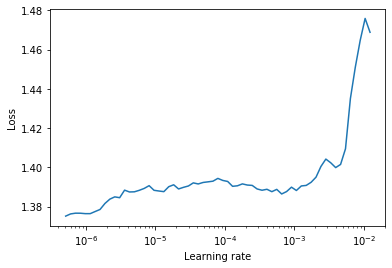

In [20]:
lr_finder.plot(skip_end=20)

In [21]:
lr_finder.reset()